# Dipsacales concordance analysis
Theses analyses address genomic conflict within the Dipsacales, a clade of ~1,100 Campanulid angiosperms. They were produced by Ian S. Gilman as part of

Lee, Aaron K., I. S. Gilman, M. Srivastav, A. Lerner, M. J. Donoghue, W. L. Clement. (_Accepted_) **Reconstructing Dipsacales phylogeny using Angiosperms353: Issues and insights.** American Journal of Botany.

For more details, see the [Wiki](https://github.com/aaklee/DipsacalesHybSeq/wiki/Concordance-analysis). Note that some taxa may be misspelled here (e.g., _Patrina triloba_ instead of _Patrinia triloba_). 

In [58]:
# Core
import re, os, glob, sys, string
import pandas as pd
from pathlib import Path
import numpy as np
# Plotting
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import MultipleLocator
from matplotlib import colors as mcolors
from matplotlib import colorbar
from ete3 import Tree, TreeStyle, TextFace,NodeStyle,faces, COLOR_SCHEMES
import toytree
import toyplot
import toyplot.pdf
import toyplot.png
import dendropy as dp

## Rerooting trees

### Jump to concordance analysis if already completed.

In [59]:
working_dir = Path("../Data/Concordance_analysis/")
unrooted_sptree_path = working_dir / "Dipsacales-species-tree.BS33.unrooted.tre"
genetreespath = working_dir / "Dipsacales-gene-trees.BS33.unrooted.trees"

Reroot the species tree and export the topology.

In [7]:
with open(working_dir / "Dipsacales-species-tree.BS33.rooted.topology.tre", "w+") as r:
    with open(unrooted_sptree_path, "r") as s:
        sptree = Tree(s.readline())
    sptree.set_outgroup("Ilex_crenata")
    r.write(sptree.write(format=9))
with open(working_dir / "Dipsacales-species-tree.BS33.rooted.tre", "w+") as r:
    r.write(sptree.write())

Reroot each of the gene trees to *Ilex*, or *Paracryhia* if *Ilex* is not in the tree, and then we'll deal with the trees that can't easily be rooted after

In [60]:
with open(working_dir/"Dipsacales-gene-trees.BS33.rooted.trees", "w+") as r:
    rooted = []
    problems = []
    with open(genetreespath, "r") as g:
        for line in g.readlines():
            genetree = Tree(line)
            if "Ilex_crenata" in genetree.get_leaf_names():
                genetree.set_outgroup("Ilex_crenata")
                rooted.append(genetree.write()+"\n")
            elif "Paracryphia_alticola" in genetree.get_leaf_names():
                genetree.set_outgroup("Paracryphia_alticola")
                rooted.append(genetree.write()+"\n")
            else:
                problems.append(genetree)
    r.writelines(rooted)
print("{} gene trees were easily rooted".format(len(rooted)))
print("{} gene trees will need to be manually rooted".format(len(problems)))

218 gene trees were easily rooted
9 gene trees will need to be manually rooted


In [61]:
fixed = []

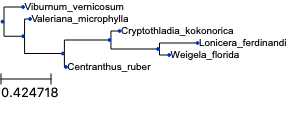

In [62]:
genetree = problems[0]
genetree.set_outgroup("Viburnum_vernicosum")
fixed.append(genetree.write()+"\n")

genetree.render("%%inline")

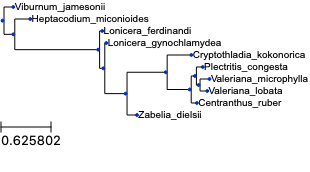

In [63]:
genetree = problems[1]
genetree.set_outgroup("Viburnum_jamesonii")
fixed.append(genetree.write()+"\n")
genetree.render("%%inline")

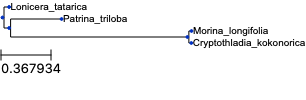

In [64]:
genetree = problems[2]
genetree.set_outgroup("Lonicera_tatarica")
fixed.append(genetree.write()+"\n")
genetree.render("%%inline")

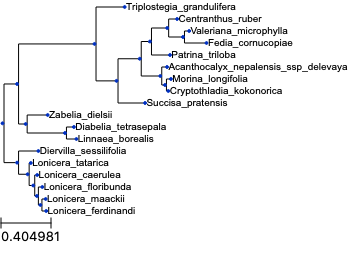

In [65]:
genetree = problems[3]
ancestor = genetree.get_common_ancestor("Triplostegia_grandulifera", "Zabelia_dielsii")
genetree.set_outgroup(ancestor)
fixed.append(genetree.write()+"\n")
genetree.render("%%inline")

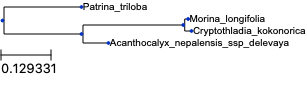

In [66]:
genetree = problems[4]
genetree.set_outgroup("Patrina_triloba")
fixed.append(genetree.write()+"\n")
genetree.render("%%inline")

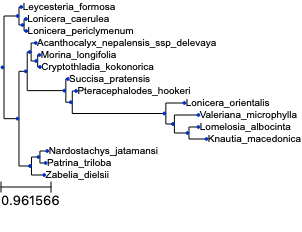

In [67]:
genetree = problems[5]
ancestor = genetree.get_common_ancestor("Lonicera_caerulea", "Leycesteria_formosa")
genetree.set_outgroup(ancestor)
fixed.append(genetree.write()+"\n")
genetree.render("%%inline")

The gene tree above is a bit wonky, but I guess that's why we're doing the concordance analysis in the first place!

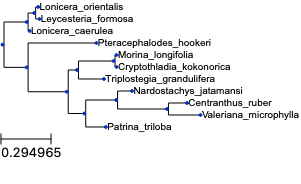

In [68]:
genetree = problems[6]
ancestor = genetree.get_common_ancestor("Lonicera_caerulea", "Leycesteria_formosa")
genetree.set_outgroup(ancestor)
fixed.append(genetree.write()+"\n")
genetree.render("%%inline")

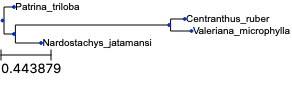

In [69]:
genetree = problems[7]
genetree.set_outgroup("Patrina_triloba")
fixed.append(genetree.write()+"\n")
genetree.render("%%inline")

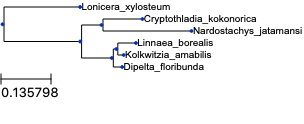

In [70]:
genetree = problems[8]
genetree.set_outgroup("Lonicera_xylosteum")
fixed.append(genetree.write()+"\n")
genetree.render("%%inline")

In [71]:
with open(working_dir/"Dipsacales-gene-trees.BS33.rooted.trees", "a") as r:
    r.writelines(fixed)

Now we're ready to go back to the command line and run the PhyParts analysis.

## Creating pie chart plots
Following Matt Johnson's [Phyparts Pie Charts notebook](https://github.com/mossmatters/MJPythonNotebooks/blob/master/PhyParts_PieCharts.ipynb). First grab all of the relevant files.

In [23]:
working_dir = Path("../Data/Concordance_analysis/")
phyparts_dir = working_dir / "phyparts"
keyfile = next(phyparts_dir.glob("*.key"))
histfile = next(phyparts_dir.glob("*.hist"))
conconfile = next(phyparts_dir.glob("*.concon.*"))

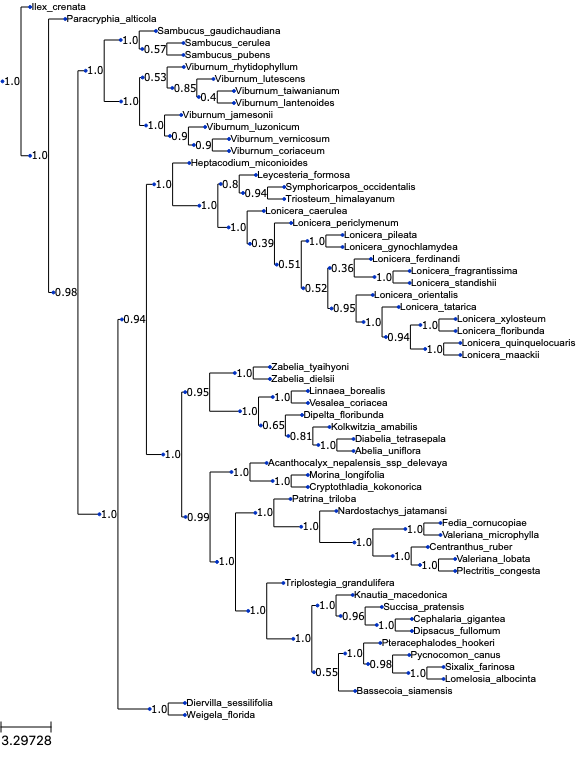

In [24]:
with open(working_dir / "Dipsacales-species-tree.BS33.rooted.tre", "r") as s:
    sptree = Tree(s.readline())
bs = TreeStyle()

def bootstrap_fn(mynode):
    if not mynode.is_leaf():
        F = TextFace(str(mynode.support))
        faces.add_face_to_node(F,mynode,0,"branch-top")
        
bs.layout_fn = bootstrap_fn
bs.mode="r"
bs.show_leaf_name = True        

sptree.render("%%inline", tree_style=bs)

### Identifying common nodes

In [25]:
phyparts_node_key = [line for line in open(keyfile)]
subtrees_dict = {n.split()[0]:Tree(n.split()[1]+";") for n in phyparts_node_key}
subtrees_topids = {}
for x in subtrees_dict:
    subtrees_topids[x] = subtrees_dict[x].get_topology_id()

for node in sptree.traverse():
    node_topid = node.get_topology_id()
    for subtree in subtrees_dict:
        if node_topid == subtrees_topids[subtree]:
            node.name = subtree

### Extracting concordance info

In [26]:
with open(conconfile) as phyparts_trees:
    concon_tree = Tree(phyparts_trees.readline())
    conflict_tree = Tree(phyparts_trees.readline())

concord_dict = {}
conflict_dict = {}

for i, node in enumerate(concon_tree.traverse()):
    node_topid = node.get_topology_id()
    for j, subtree in enumerate(subtrees_dict):
        if node_topid == subtrees_topids[subtree]:
            concord_dict[subtree] = node.support
            
for i, node in enumerate(conflict_tree.traverse()):
    node_topid = node.get_topology_id()
    for j, subtree in enumerate(subtrees_dict):
        if node_topid == subtrees_topids[subtree]:
            conflict_dict[subtree] = node.support

### Plotting node numbers

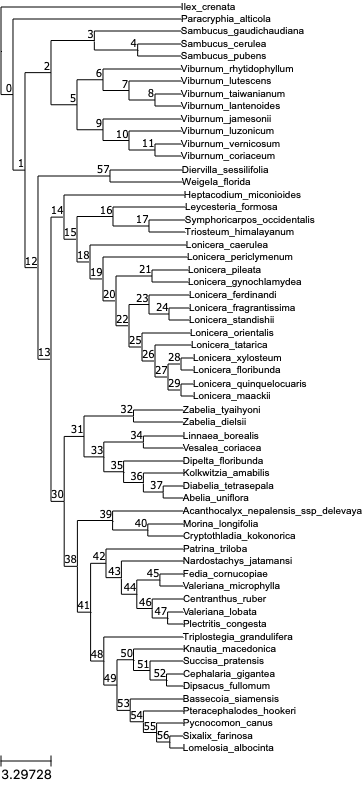

In [27]:
node_tree = sptree.copy()
node_tree.set_outgroup("Ilex_crenata")
node_tree.ladderize()

nstyle = NodeStyle()
nstyle["size"] = 0
for n in node_tree.traverse():
    n.set_style(nstyle)

node_tree.convert_to_ultrametric()  #Makes the tips sorta line up...  
ns = TreeStyle()

def node_name(node):
    if not node.is_leaf():
        F = TextFace(node.name)
        faces.add_face_to_node(face=F, node=node, column=0, position="branch-top")
        
ns.layout_fn = node_name
ns.mode="r"
ns.show_leaf_name = True        

node_tree.render("../Figures/Concordance-analysis/Node-tree.pdf", tree_style=ns)
node_tree.render("%%inline",tree_style=ns)

### Creating pie charts

In [28]:
phyparts_hist = [line for line in open(histfile)]
phyparts_pies = {}
phyparts_dict = {}

total_genes=227
for n in phyparts_hist:
    n = n.split(",")
    tot_genes = float(n.pop(-1))
    node_name = n.pop(0)[4:]
    concord = float(n.pop(0))
    concord = concord_dict[node_name]
    all_conflict = conflict_dict[node_name]
    
    if len(n) > 0:   
        most_conflict = max([float(x) for x in n])
    else:
        most_conflict = 0.0
    
    adj_concord = (concord/total_genes) * 100 
    adj_most_conflict = (most_conflict/total_genes) * 100
    other_conflict = (all_conflict - most_conflict) / total_genes * 100
    the_rest = (total_genes - concord - all_conflict) / total_genes * 100
    
    pie_list = [adj_concord,adj_most_conflict,other_conflict,the_rest]
        
    phyparts_pies[node_name] = pie_list
    
    phyparts_dict[node_name] = [int(round(concord,0)),int(round(tot_genes-concord,0))]

### Visualizing pie charts
I altered the aesthetics of Matt's original code a little. I'm partial to the XKCD color schemes...

In [29]:
def phyparts_pie_layout(mynode):
    if mynode.name in phyparts_pies:
        pie= faces.PieChartFace(phyparts_pies[mynode.name],
                              colors = [mcolors.rgb2hex("xkcd:emerald"),
                                        mcolors.rgb2hex("xkcd:amber"),
                                        mcolors.rgb2hex("xkcd:dusty red"),
                                        mcolors.rgb2hex("xkcd:light gray")],
                              width=50, height=50)
        pie.border.width = None
        pie.opacity = 1.0
        faces.add_face_to_node(pie,mynode, 0, position="branch-right")
        
        concord_text = faces.TextFace(str(int(concord_dict[mynode.name]))+'   ',fsize=20)
        conflict_text = faces.TextFace(str(int(conflict_dict[mynode.name]))+'   ',fsize=20)
        
        faces.add_face_to_node(concord_text,mynode,0,position = "branch-top")
        faces.add_face_to_node(conflict_text,mynode,0,position="branch-bottom")
        
        
    else:
        F = faces.TextFace(mynode.name,fsize=20)
        faces.add_face_to_node(F,mynode,0,position="aligned")

The plots below are early figure versions that were superseded for publication. I included them here only as an example of plotting with `ete3`, which I find to be difficult in general. Disregard the colors and naming conventions here because these were done before we settled on appropriate clade names; they're not too far off though, and shouldn't be misleading.

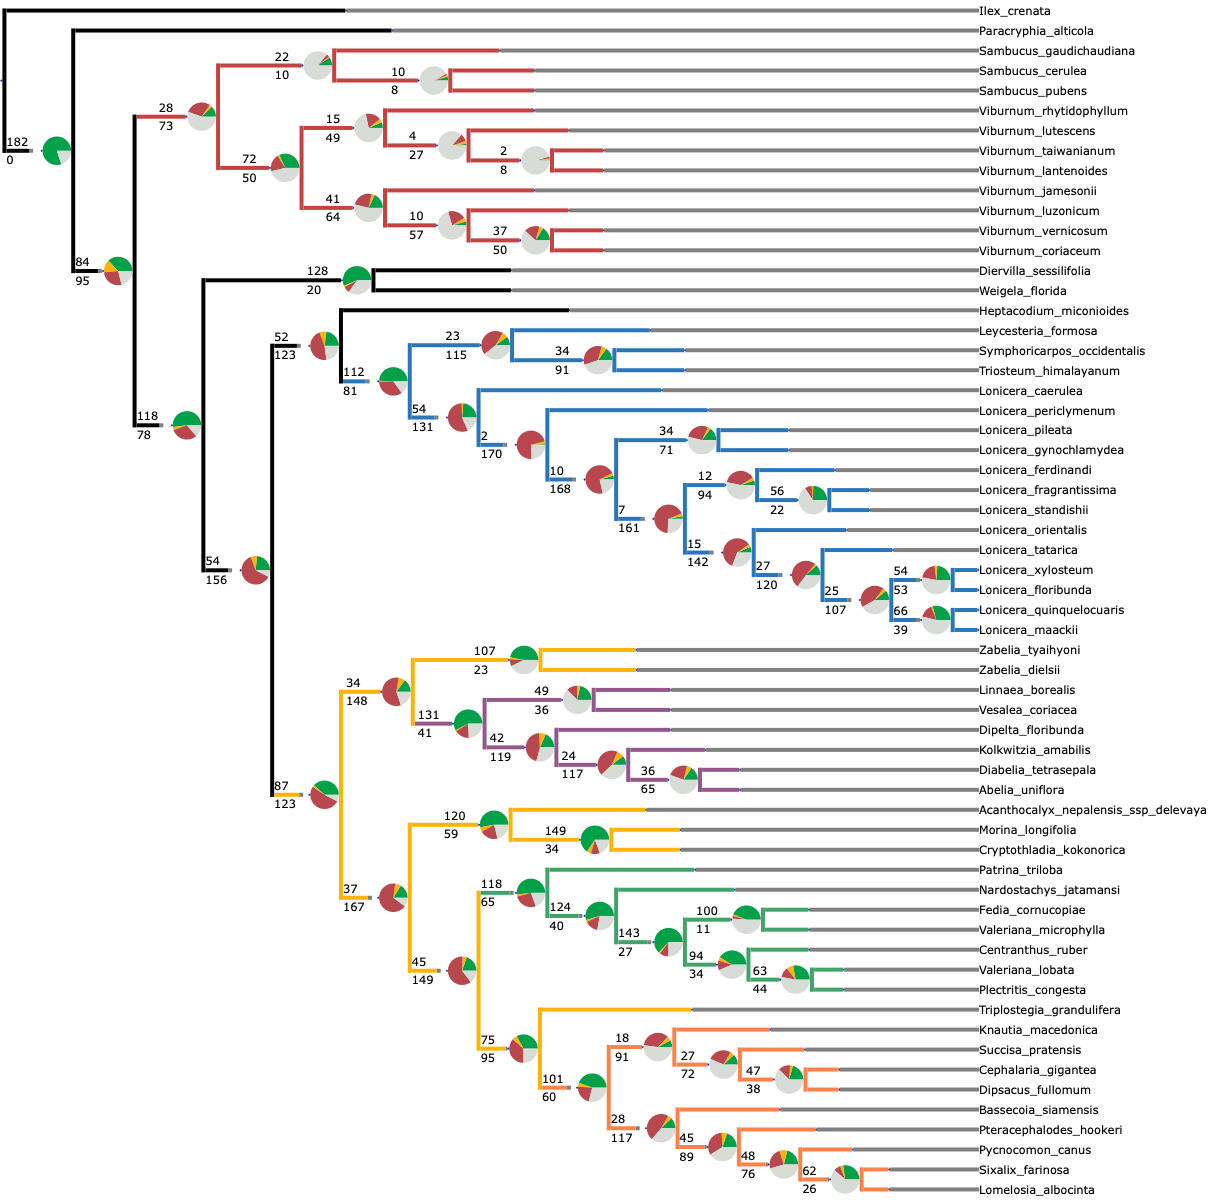

In [30]:
plot_tree = sptree.copy()
plot_tree.set_outgroup("Ilex_crenata")
plot_tree.ladderize()

ts = TreeStyle()
ts.show_leaf_name = False
        
ts.layout_fn = phyparts_pie_layout

adoxaceae_style = NodeStyle()
adoxaceae_style["vt_line_color"] = mcolors.rgb2hex("xkcd:reddish")
adoxaceae_style["hz_line_color"] = mcolors.rgb2hex("xkcd:reddish")

caprifoliaceae_style = NodeStyle()
caprifoliaceae_style["vt_line_color"] = mcolors.rgb2hex("xkcd:bluish")
caprifoliaceae_style["hz_line_color"] = mcolors.rgb2hex("xkcd:bluish")

morinaceae_style = NodeStyle()
morinaceae_style["vt_line_color"] = mcolors.rgb2hex("xkcd:amber")
morinaceae_style["hz_line_color"] = mcolors.rgb2hex("xkcd:amber")

linnaeeae_style = NodeStyle()
linnaeeae_style["vt_line_color"] = mcolors.rgb2hex("xkcd:purplish")
linnaeeae_style["hz_line_color"] = mcolors.rgb2hex("xkcd:purplish")

valerianaceae_style = NodeStyle()
valerianaceae_style["vt_line_color"] = mcolors.rgb2hex("xkcd:greenish")
valerianaceae_style["hz_line_color"] = mcolors.rgb2hex("xkcd:greenish")

dipsacaceae_style = NodeStyle()
dipsacaceae_style["vt_line_color"] = mcolors.rgb2hex("xkcd:orangish")
dipsacaceae_style["hz_line_color"] = mcolors.rgb2hex("xkcd:orangish")

for n in plot_tree.traverse():    
    if n == plot_tree.get_common_ancestor("Sambucus_pubens", "Viburnum_jamesonii"):
        for d in n.traverse(): d.set_style(adoxaceae_style)
    elif n == plot_tree.get_common_ancestor("Triosteum_himalayanum", "Lonicera_pileata"):
        for d in n.traverse(): d.set_style(caprifoliaceae_style)
    elif n == plot_tree.get_common_ancestor("Zabelia_dielsii", "Morina_longifolia"):
        for d in n.traverse(): d.set_style(morinaceae_style)
    elif n == plot_tree.get_common_ancestor("Linnaea_borealis", "Abelia_uniflora"):
        for d in n.traverse(): d.set_style(linnaeeae_style)
    elif n == plot_tree.get_common_ancestor("Patrina_triloba", "Valeriana_lobata"):
        for d in n.traverse(): d.set_style(valerianaceae_style)
    elif n == plot_tree.get_common_ancestor("Dipsacus_fullomum", "Sixalix_farinosa"):
        for d in n.traverse(): d.set_style(dipsacaceae_style)
            
    n.img_style["vt_line_width"] = 7.5
    n.img_style["hz_line_width"] = 7.5
    
ts.draw_guiding_lines = True
# ts.guiding_lines_color = "black"
ts.guiding_lines_type = 0
ts.scale = 50
ts.branch_vertical_margin = 10
ts.show_scale = False
plot_tree.convert_to_ultrametric()    
# plot_tree.render("../Figures/FINAL_PIE_CHARTS.left-tree.png", tree_style=ts, units="px", h=3600, w=3600, dpi=96, ) 
plot_tree.render("%%inline", tree_style=ts, units="in", h=12.5, dpi=96)

The plots above show an additional feature left out of the final version: the total number of concordant and discordant gene trees for each node, shown above and below branches, respectively.

It looks like Adoxaceae and Caprifolioideae nodes are informed by very different numbers of gene trees. 

In [38]:
adox_nodes = np.arange(2,12)
non_adox_info = []
adox_info = []
for k, v in phyparts_pies.items():
    if int(k) in adox_nodes:
        adox_info.append(sum(v[:-1]))
    else:
        non_adox_info.append(sum(v[:-1]))
        
caprifolioideae_nodes = np.arange(18,30)
caprifolioideae_info = []
for k, v in phyparts_pies.items():
    if int(k) in caprifolioideae_nodes:
        caprifolioideae_info.append(sum(v[:-1]))

print("Caprifolioideae: {:3.0f} +/- {:2.0f}".format(np.mean(caprifolioideae_info)*227/100, np.std(caprifolioideae_info)*227/100))        
print("Adoxaceae: {:2.0f} +/- {:2.0f}".format(np.mean(adox_info)*227/100, np.std(adox_info)*227/100))
print("Other: {:3.0f} +/- {:2.0f}".format(np.mean(non_adox_info)*227/100, np.std(non_adox_info)*227/100))

Caprifolioideae: 137 +/- 34
Adoxaceae: 64 +/- 38
Other: 148 +/- 37


Indeed, Caprifoliodeae nodes look like most of the rest of the tree, while many fewer gene trees are informing relationships within the Adoxaceae.

Now I'll use Deren Eaton's [`toytree`](https://toytree.readthedocs.io/en/latest/) package to plot a tree with BS support values. Toytree is great for drawing simple and clean phylogenies, but it can't readily do all of things we want like plotting the pie charts.

In [39]:
dips = toytree.tree(str(working_dir / "Dipsacales-species-tree.BS33.rooted.tre"))

In [40]:
canvas = toyplot.Canvas(width=3600, height=3600, style={"background-color":"white"})

axes = canvas.cartesian(bounds=(1000, 3500, 0, 3600))
axes.show = False

cmap = plt.cm.RdYlGn
node_colors = []
node_sizes = []
for s in dips.get_node_values('support', show_root=0, show_tips=0):
    try:
        node_colors.append(mcolors.to_hex(cmap(float(s))))
        node_sizes.append(50)
    except ValueError:
        node_colors.append("white")
        node_sizes.append(0)


ecolors = dips.get_edge_values_from_dict({
    ("Sambucus_pubens", "Viburnum_jamesonii"): mcolors.rgb2hex("xkcd:reddish"),
    ("Triosteum_himalayanum", "Lonicera_pileata"):mcolors.rgb2hex("xkcd:bluish"),
    ("Zabelia_dielsii", "Morina_longifolia"):mcolors.rgb2hex("xkcd:amber"),
    ("Linnaea_borealis", "Abelia_uniflora"):mcolors.rgb2hex("xkcd:purplish"),
    ("Patrina_triloba", "Valeriana_lobata"):mcolors.rgb2hex("xkcd:greenish"),
    ("Dipsacus_fullomum", "Sixalix_farinosa"):mcolors.rgb2hex("xkcd:orangish")})
        
fillwidth = max([len(t) for t in dips.get_tip_labels()])
tip_labels = [label if "Patrina" not in label else label.replace("Patrina", "Patrinia") for label in dips.get_tip_labels()]
tip_labels = [re.sub("_", " ", tip).ljust(fillwidth) for tip in tip_labels]
dips.ladderize().draw(axes=axes, tip_labels=tip_labels, tip_labels_align=True, edge_colors=ecolors,
                      tip_labels_style={"font-size":"40px"},
                      node_labels=None, node_sizes=node_sizes, node_colors=node_colors, 
                      use_edge_lengths=False, edge_widths=10, node_style={"stroke":"black"}, 
                      scalebar=False, layout="left");

<svg class="toyplot-canvas-Canvas" height="3600.0px" id="t14c48320f9eb4dffb539b3a72f6eeeef" preserveAspectRatio="xMidYMid meet" style="background-color:white;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 3600.0 3600.0" width="3600.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> Lomelosia albocinta Sixalix farinosa Pycnocomon canus Pteracephalodes hookeri Bassecoia siamensis Dipsacus fullomum Cephalaria gigantea Succisa pratensis Knautia macedonica Triplostegia grandulifera Plectritis congesta Valeriana lobata Centranthus ruber Valeriana microphylla Fedia cornucopiae Nardostachys jatamansi Patrinia triloba Cryptothladia kokonorica Morina longifolia Acanthocalyx nepalensis ssp delevaya Abelia uniflora Diabelia tetrasepala Kolkwitzia amabilis Dipelta floribunda Vesalea coriacea Linnaea borealis Zabelia dielsii Zabelia tyaihyoni Lonicera maackii Lonicera quinquelocuaris Lonicera floribunda Lonicera xylosteum Lonicera tatarica Lonicera orientalis Lonicera standishii Lonicera fragrantissima Lonicera ferdinandi Lonicera gynochlamydea Lonicera pileata Lonicera periclymenum Lonicera caerulea Triosteum himalayanum Symphoricarpos occidentalis Leycesteria formosa Heptacodium miconioides Weigela florida Diervilla sessilifolia Viburnum coriaceum Viburnum vernicosum Viburnum luzonicum Viburnum jamesonii Viburnum lantenoides Viburnum taiwanianum Viburnum lutescens Viburnum rhytidophyllum Sambucus pubens Sambucus cerulea Sambucus gaudichaudiana Paracryphia alticola Ilex crenata

In [104]:
# toyplot.png.render(canvas, "../Figures/FINAL_SPECIES_TREE.right-tree.png", height="3600px")

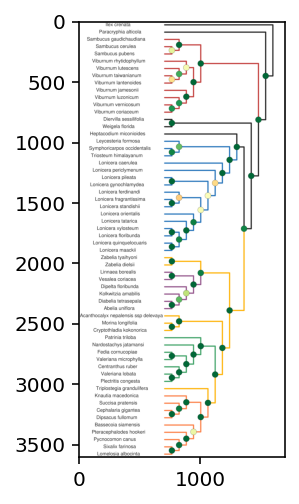

In [7]:
righttree = plt.imread("../Figures/Concordance-analysis/FINAL_SPECIES_TREE.right-tree.png")
plt.imshow(righttree[:, 1900:3600]);

/Users/iangilman/miniconda3/envs/phylo/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


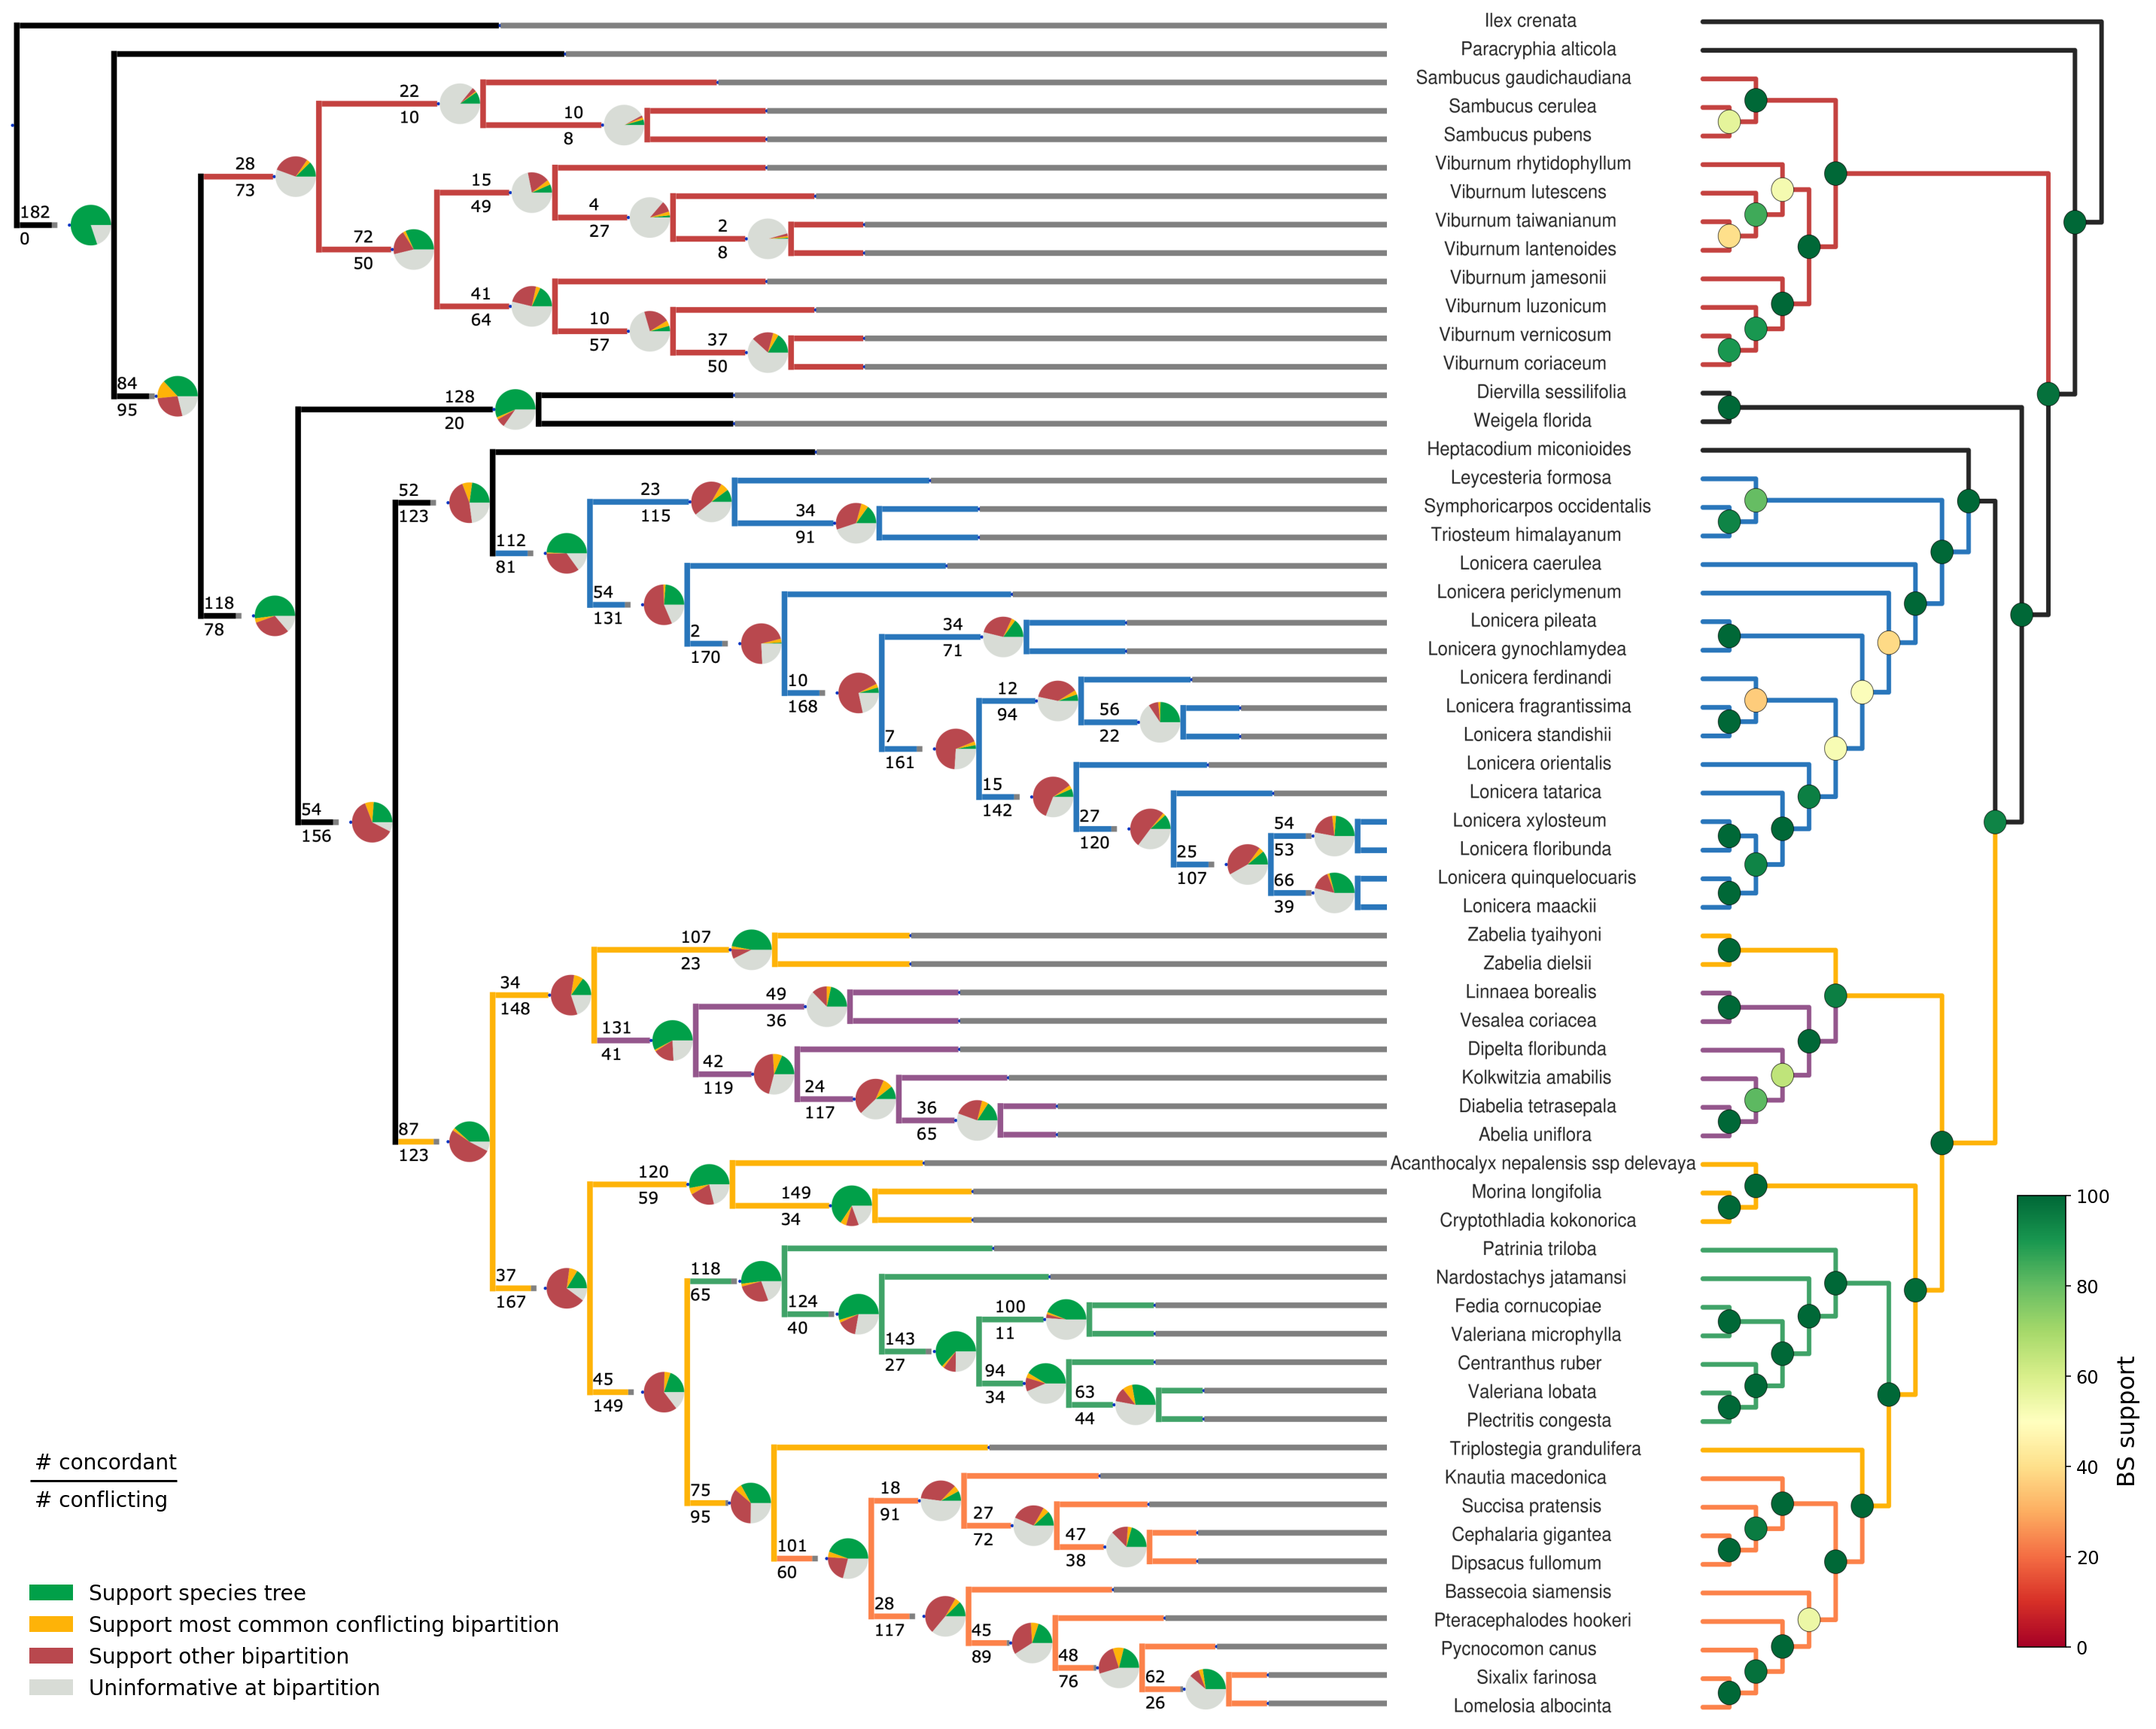

In [112]:
fig, ax = plt.subplots(figsize = (20, 20))

leftree = plt.imread("../Figures/FINAL_PIE_CHARTS.left-tree.png")[:, :]
righttree = plt.imread("../Figures/FINAL_SPECIES_TREE.right-tree.png")[:, 1900:3600]

ax.imshow(leftree, extent=(0, 3600, 0, 3600))
ax.imshow(righttree, extent=(2900, 4500, 0, 3600))

ax.set_xlim(0, 4500)
ax.set_ylim(0, 3600)

ax.hlines(y=500, xmin=40, xmax=350, colors="black")
ax.text(x = 50, y = 525, s= "# concordant", size=14)
ax.text(x = 50, y = 445, s= "# conflicting", size=14)

greenpatch = mpatches.Patch(color="xkcd:emerald", label='Support species tree')
yellowpatch = mpatches.Patch(color="xkcd:amber", label='Support most common conflicting bipartition')
redpatch = mpatches.Patch(color="xkcd:dusty red", label='Support other bipartition')
greypatch = mpatches.Patch(color="xkcd:light grey", label='Uninformative at bipartition') 

ax.legend(handles=[greenpatch, yellowpatch, redpatch, greypatch], fontsize=14, loc='lower left', frameon=False)

cmap = plt.cm.RdYlGn
norm = mcolors.Normalize(vmin=0, vmax=100)
cax = fig.add_axes([4200/4500, 500/3600, 100/4500, 750/3600]) # [x0, y0, width, height]
cbar = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cbar.ax.tick_params(labelsize=12)
cbar.set_label("BS support", size=16)

ax.axis("off")

plt.tight_layout()

For the final figure I simply plotted all of the pies with their associated node number so that they could be lifted onto to final species tree Adobe Illustrator file.

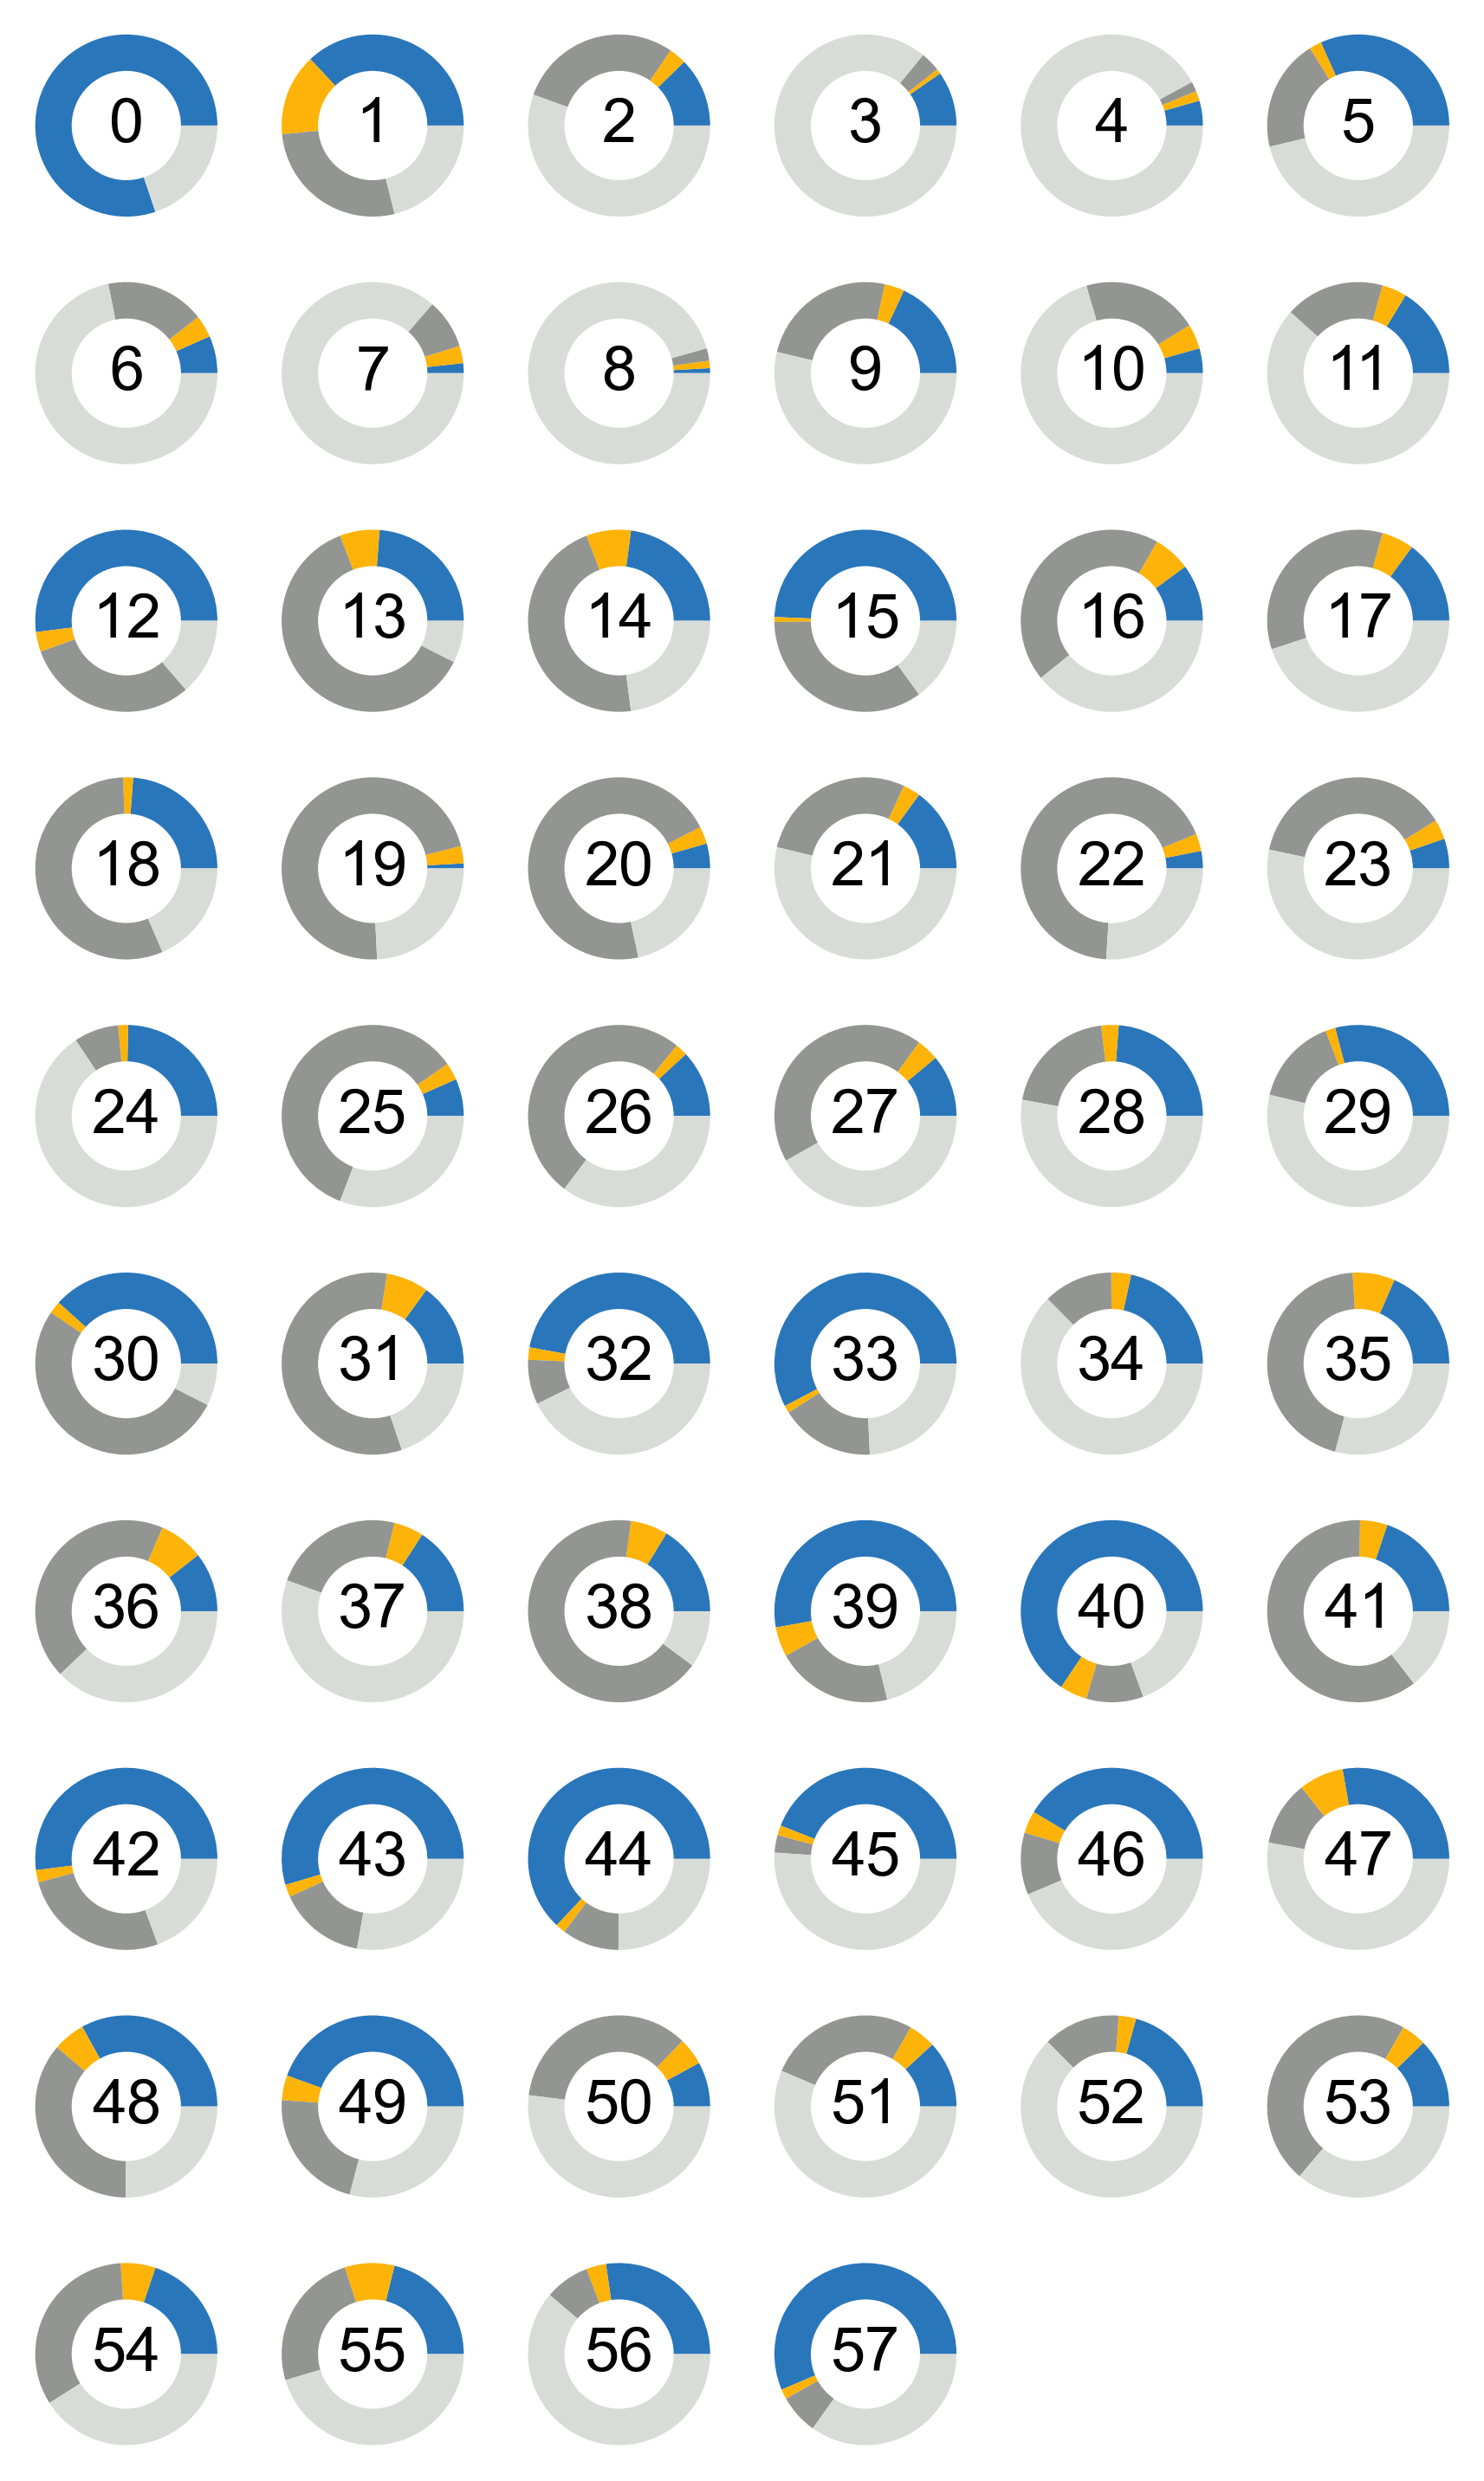

In [90]:
arialfont = {'fontname':'Arial'}

fig, ax = plt.subplots(nrows=10, ncols=6, figsize=(12,20))

colors = ["xkcd:bluish", "xkcd:amber", "xkcd:grey", "xkcd:light grey"]

for i, ax in enumerate(ax.flat):
    if i>=len(phyparts_pies):
        ax.axis('off')
    else:
        ax.pie(phyparts_pies[str(i)], startangle=0, colors=colors)
        centre_circle = plt.Circle((0,0), 0.6, color='black', fc='white',linewidth=0)
        ax.add_artist(centre_circle)
        ax.text(x=0, y=0, s=str(i), horizontalalignment='center', verticalalignment='center', size=36, **arialfont)

plt.tight_layout()
plt.savefig("../Figures/Concordance/All-pies.pdf", format="pdf", bbox_inches='tight', dpi=300, transparent=True)
plt.savefig("../Figures/Concordance/All-pies.lowres.pdf", format="png", bbox_inches='tight', dpi=300, transparent=True)

# _Heptacodium_ and _Zabelia_ alternative placements
## _Heptacodium_
Concordance analysis does not assess the magnitude of disparity between a given gene tree and the species tree topology, and it is possible that alternative topologies do not significantly violate the placement of _Heptacodium_ as sister to the Caprifolieae. For example, if any member of Caprifolieae crosses the bipartition (Caprifolioideae | everything else), that gene tree would not be congruent with the species tree at that node, even if _Heptacodium_ remained sister to the remaining members of Caprifolieae. To address this, I'll tabulate the number of gene trees that support the two hypothesized placements of *Heptacodium*: sister to the Caprifolieae or sister to the Linnina.

First, I'll get the MRCA nodes of the major clades and the lists of taxa they contain.

In [48]:
caprifolieae_node = dips.get_mrca_idx_from_tip_labels(["Leycesteria_formosa", "Lonicera_maackii"])
caprifolieae_taxa = dips.get_tip_labels(idx=caprifolieae_node)
linnaeeae_node = dips.get_mrca_idx_from_tip_labels(["Linnaea_borealis", "Abelia_uniflora"])
linnaeeae_taxa = dips.get_tip_labels(idx=linnaeeae_node)
linnina_node = dips.get_mrca_idx_from_tip_labels(["Zabelia_dielsii", "Sixalix_farinosa"])
linnina_taxa = dips.get_tip_labels(idx=linnina_node)
morinaceae_node = dips.get_mrca_idx_from_tip_labels(["Morina_longifolia", "Acanthocalyx_nepalensis_ssp_delevaya"])
morinaceae_taxa = dips.get_tip_labels(idx=morinaceae_node)
zabelia_taxa = ["Zabelia_tyaihyoni", "Zabelia_dielsii"]
valerianaceae_node = dips.get_mrca_idx_from_tip_labels(["Patrina_triloba", "Valeriana_lobata"])
valerianaceae_taxa = dips.get_tip_labels(idx=valerianaceae_node)
dipsacoideae_node = dips.get_mrca_idx_from_tip_labels(["Triplostegia_grandulifera", "Sixalix_farinosa"])
dipsacoideae_taxa = dips.get_tip_labels(idx=dipsacoideae_node)

Now I'll extract all of the gene trees that have 
1. _Heptacodium_
2. At least one member of Caprifolieae
3. At least one member of Linnina

In [49]:
genetreespath = working_dir / "Dipsacales-gene-trees.BS33.rooted.trees"

hept_testable = []
with open(genetreespath, "r") as f:
    for line in f.readlines():
        if ("Heptacodium_miconioides" in line) and \
            any([cap in line for cap in caprifolieae_taxa]) and \
            any([lin in line for lin in linnina_taxa]):
            hept_testable.append(line)

Now I'll bin the gene trees into those where _Heptacodium_ is sister to a group of Caprifolieae taxa and those where it's sister to a group of Linnina taxa.

In [79]:
# Unambiguously support
hept_cap = 0
hept_lin = 0
# Ambiguous
hept_ambig = 0

for gt in [toytree.tree(newick) for newick in hept_testable]:
    hept_idx = gt.get_mrca_idx_from_tip_labels("Heptacodium_miconioides")
    hept_node = [node for node in gt.treenode.traverse("levelorder") if node.idx==hept_idx][0]
    sister_taxa = hept_node.get_sisters()[0].get_leaf_names()
    sister_caps = list(set(caprifolieae_taxa).intersection(set(sister_taxa)))
    sister_lins = list(set(linnina_taxa).intersection(set(sister_taxa)))
    
    if (len(sister_caps) > 0) and (len(sister_lins)==0): # Hept only sister to Cap taxa
            hept_cap+=1
    elif (len(sister_lins) > 0) and (len(sister_caps)==0): # Hept has onnly sister Lin taxa
            hept_lin+=1
    else:
        hept_ambig+=1

print("{} gene trees".format(len(hept_testable)))
print("Support Hept+Cap: {} ({:2.2%})".format(hept_cap, hept_cap/len(hept_testable)))
print("Support Hept+Lin: {} ({:2.2%})".format(hept_lin, hept_lin/len(hept_testable)))
print("Ambiguous: {} ({:2.2%})".format(hept_ambig, hept_ambig/len(hept_testable)))

147 gene trees
Support Hept+Cap: 75 (51.02%)
Support Hept+Lin: 32 (21.77%)
Ambiguous: 40 (27.21%)


So, despite the large red slice of the pie chart at the node that includes *Heptacodium*, Caprifolieae, and Linnaeeae, most gene trees support the relationship (*Heptacodium*, Caprifolieae). No we can repeat this with *Zabelia*.

## *Zabelia* position
It remains unclear whether *Zabelia* is more closely related to the Linnaeeae or Morinaceae. Some studies have found is sister to the Dipsacoideae, but this is less common.

In [80]:
zab_testable = []
with open(genetreespath, "r") as f:
    for line in f.readlines():
        if any([zab in line for zab in zabelia_taxa]) and \
            any([mor in line for mor in morinaceae_taxa]) and \
            any([dip in line for dip in dipsacoideae_taxa]) and \
            any([val in line for val in valerianaceae_taxa]) and \
            any([lin in line for lin in linnaeeae_taxa]):
            zab_testable.append(line)
print(len(zab_testable))

177


This one is little more tricky since their are multiple comparisons, so I'll first break them down by majority of sister taxa, and then excluded those which are somewhat ambiguous.

In [81]:
# Unambiguously support
zab_mor = 0
zab_dip = 0
zab_lin = 0
zab_val = 0
# Sister to a majority of one clade
favor_mor = 0
favor_dip = 0
favor_lin = 0
favor_val = 0
# Ambiguous
zab_ambig = 0

for gt in [toytree.tree(newick) for newick in zab_testable]:
    try:
        zab_idx = gt.get_mrca_idx_from_tip_labels(zabelia_taxa)
    except:
        zab_idx = gt.get_mrca_idx_from_tip_labels([s for s in gt.get_tip_labels() if "Zabelia" in s].pop())
    zab_node = [node for node in gt.treenode.traverse("levelorder") if node.idx==zab_idx][0]
    sister_taxa = zab_node.get_sisters()[0].get_leaf_names()
    sister_mors = list(set(morinaceae_taxa).intersection(set(sister_taxa)))
    sister_dips = list(set(dipsacoideae_taxa).intersection(set(sister_taxa)))
    sister_lins = list(set(linnaeeae_taxa).intersection(set(sister_taxa)))
    sister_vals = list(set(valerianaceae_taxa).intersection(set(sister_taxa)))

    if len(sister_mors) >  max(len(sister_dips), len(sister_lins), len(sister_vals)):
        favor_mor+=1
        if len(sister_lins)==len(sister_dips)==len(sister_vals)==0:
            zab_mor+=1
        else:
            zab_ambig+=1
    elif len(sister_lins) > max(len(sister_dips), len(sister_mors), len(sister_vals)):
        favor_lin+=1
        if len(sister_mors)==len(sister_dips)==len(sister_vals)==0:
            zab_lin+=1
        else:
            zab_ambig+=1
    elif len(sister_dips) > max(len(sister_lins), len(sister_mors), len(sister_vals)):
        favor_dip+=1
        if len(sister_mors)==len(sister_lins)==len(sister_vals)==0:
            zab_dip+=1
        else:
            zab_ambig+=1
    elif len(sister_vals) > max(len(sister_lins), len(sister_mors), len(sister_dips)):
        favor_val+=1
        if len(sister_vals) > len(sister_mors)==len(sister_lins)==len(sister_dips)==0:
            zab_val+=1
        else:
            zab_ambig+=1
    else:
        zab_ambig+=1
print("{} gene trees".format(len(zab_testable)))
print("Favor Zab+Mor: {} ({:2.2%})\n\tUnambiguously: {} ({:2.2%})".format(favor_mor, favor_mor/len(zab_testable), zab_mor, zab_mor/len(zab_testable)))
print("Favor Zab+Lin: {} ({:2.2%})\n\tUnambiguously: {} ({:2.2%})".format(favor_lin, favor_lin/len(zab_testable), zab_lin, zab_lin/len(zab_testable)))
print("Favor Zab+Dip: {} ({:2.2%})\n\tUnambiguously: {} ({:2.2%})".format(favor_dip, favor_dip/len(zab_testable), zab_dip, zab_dip/len(zab_testable)))
print("Favor Zab+Val: {} ({:2.2%})\n\tUnambiguously: {} ({:2.2%})".format(favor_val, favor_val/len(zab_testable), zab_val, zab_val/len(zab_testable)))
print("Ambiguous: {} ({:.2})".format(zab_ambig, zab_ambig/len(zab_testable)))

177 gene trees
Favor Zab+Mor: 37 (20.90%)
	Unambiguously: 35 (19.77%)
Favor Zab+Lin: 52 (29.38%)
	Unambiguously: 49 (27.68%)
Favor Zab+Dip: 47 (26.55%)
	Unambiguously: 12 (6.78%)
Favor Zab+Val: 15 (8.47%)
	Unambiguously: 6 (3.39%)
Ambiguous: 75 (0.42)


Now I'll plot these as pie charts.

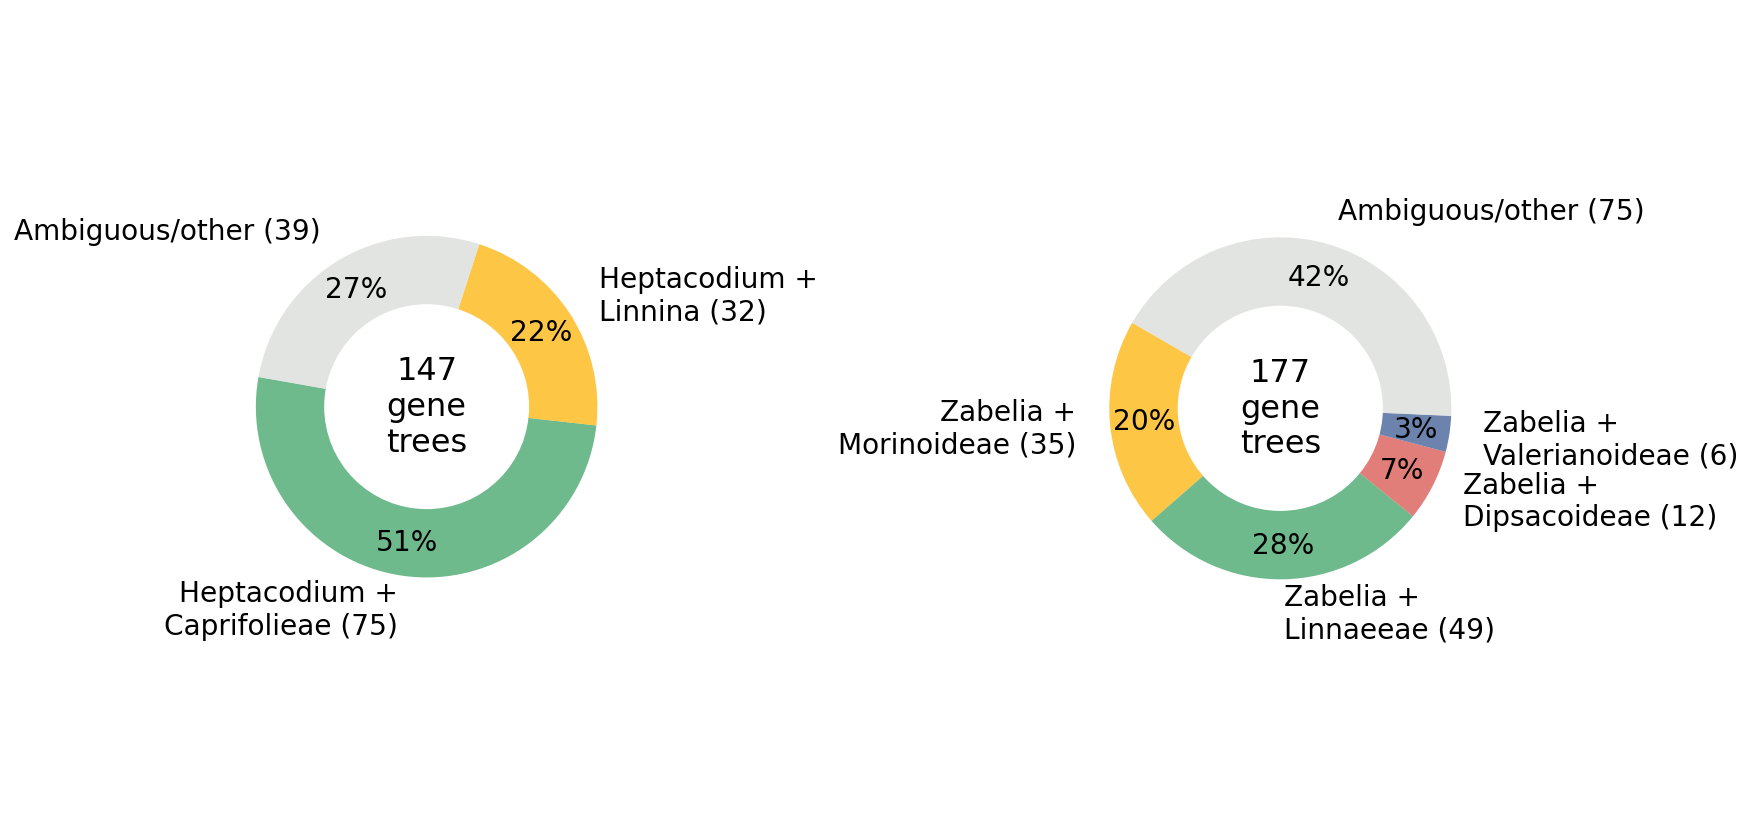

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# First pie
labels=["Heptacodium +\nCaprifolieae ({})".format(hept_cap),
        "Heptacodium +\nLinnina ({})".format(hept_lin),
        "Ambiguous/other ({})".format(146-hept_cap-hept_lin)]
sizes = [hept_cap, hept_lin, len(hept_testable)-hept_cap-hept_lin]

colors = ["xkcd:greenish","xkcd:amber", "xkcd:light grey"]

patches, texts, autotexts = ax[0].pie(sizes, startangle=170, labels=labels, colors=colors, 
                                      autopct='%1.f%%', pctdistance=0.8, labeldistance=1.2)

# Edit patches and text
for p in patches:
    p.set_alpha(0.75)
for i, t in enumerate(autotexts):
    t.set_size(14)
    texts[i].set_size(14)
# Add center cirle with text
centre_circle0 = plt.Circle((0,0), 0.6, color='black', fc='white',linewidth=0)
ax[0].add_artist(centre_circle0)
ax[0].text(x=0, y=0, s="{}\ngene\ntrees".format(len(hept_testable)), 
           horizontalalignment='center', verticalalignment='center', size=16)
ax[0].axis('equal')

# Second pie
labels=["Zabelia +\nMorinoideae ({})".format(zab_mor),
        "Zabelia +\nLinnaeeae ({})".format(zab_lin),
        "Zabelia +\nDipsacoideae ({})".format(zab_dip),
        "Zabelia +\nValerianoideae ({})".format(zab_val),
        "Ambiguous/other ({})".format(len(zab_testable)-zab_dip-zab_lin-zab_mor-zab_val)]
sizes = [zab_mor, zab_lin, zab_dip, zab_val, len(zab_testable)-zab_dip-zab_lin-zab_mor-zab_val]

colors = ["xkcd:amber", "xkcd:greenish", "xkcd:pale red", "xkcd:denim blue", "xkcd:light grey"]

patches, texts, autotexts = ax[1].pie(sizes, startangle=150, labels=labels, colors=colors, 
                                      autopct='%1.f%%', pctdistance=0.8, labeldistance=1.2)

# Edit patches and text
for p in patches:
    p.set_alpha(0.75)
for i, t in enumerate(autotexts):
    t.set_size(14)
    texts[i].set_size(14)
# Add center cirle with text
centre_circle1 = plt.Circle((0,0), 0.6, color='black', fc='white',linewidth=0)
ax[1].add_artist(centre_circle1)
ax[1].text(x=0, y=0, s="{}\ngene\ntrees".format(len(zab_testable)), 
           horizontalalignment='center', verticalalignment='center', size=16)
ax[1].axis('equal')

plt.tight_layout()
plt.savefig("../Figures/Concordance/Hept-Zab_concordance-pies.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.savefig("../Figures/Concordance/Hept-Zab_concordance-pies.lowres.png", format="png", dpi=150, bbox_inches="tight")